In [ ]:
!apt-get install -y build-essential python-dev python-numpy python3-dev python3-numpy libjpeg-dev zlib1g-dev libpng-dev


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz


In [ ]:
%cd ta-lib
!./configure --prefix=/usr
!make
!make install


In [ ]:
!pip install Ta-Lib


In [ ]:
pip install mpl-finance


Since the below code is only fetching data from an API and performing some calculations on it, there is no need for any preprocessing steps like missing value replacement, standardization, or normalization. However, it's always a good practice to check for missing values and outliers in the data, and handle them appropriately before performing any analysis. And

Update the code such that it include buy/ sell signal

In [ ]:
import datetime as dt

In [ ]:
def get_daily_data(symbol):
  _start = dt.date(2022,4,30)
  _end = dt.date(2022,8,30)
  df = yf.download(symbol, start = _start, end = _end)
  df = df.fillna(method='ffill')
  return df

def check_uptrend(data):
  if data['fast_ma'] > data['slow_ma'] and data['Close'] > data['fast_ma']:
      return True
  else:
      return False

def check_inside_days(data):
  if data['curr_range'] < data['prev_range']:
      return True
  else:
      return False

def check_volatility_contraction(data):
  if data['curr_volume'] < data['avg_volume']:
      return True
  else:
      return False

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def backtest(symbol, start, end, initial_capital, risk_factor):

    # retrieve data using Yahoo Finance API
    data = get_daily_data(symbol)

    data['slow_ma'] = data['Close'].rolling(window=20).mean()
    data['fast_ma'] = data['Close'].rolling(window=10).mean()

    data['prev_range'] = data['High'].shift(1) - data['Low'].shift(1)
    data['curr_range'] = data['High'] - data['Low']

    data['avg_volume'] = data['Volume'][-25:].mean()
    data['curr_volume'] = data['Volume']

    # add columns for strategy
    data["prev_close"] = data["Close"].shift(1)
    data["prev_low"] = data["Low"].shift(1)
    data["prev_high"] = data["High"].shift(1)
    data["prev_vol"] = data["Volume"].shift(1)

    # drop rows with missing data
    data.dropna(inplace=True)

    # calculate initial position size
    initial_position = initial_capital * risk_factor / data.iloc[0]["prev_close"]

    # initialize variables for tracking performance and plot
    position = 0
    buy_price = 0
    num_trades = 0
    num_wins = 0
    num_losses = 0
    total_pnl = 0
    plot_data = data.loc[:, ['Open', 'High', 'Low', 'Close']]
    plot_data['Signal'] = None

    # iterate over rows in the data
    for index, row in data.iterrows():
      # display(row)
        # check conditions for entering a long position
        if check_uptrend(row) and check_inside_days(row) and check_volatility_contraction(row):
            position = initial_position
            buy_price = row["Open"]
            num_trades += 1
            plot_data.loc[index, 'Signal'] = 'Buy'

        # check conditions for exiting the long position
        elif position > 0 and not (check_uptrend(row) and check_inside_days(row) and check_volatility_contraction(row)):

            # exit long position
            sell_price = row["Open"]
            pnl = (sell_price - buy_price) * position
            total_pnl += pnl
            position = 0
            num_trades += 1
            plot_data.loc[index, 'Signal'] = 'Sell'

            # update win/loss counters
            if pnl > 0:
                num_wins += 1
            else:
                num_losses += 1

    # calculate performance metrics
    win_rate = num_wins / num_trades if num_trades > 0 else 0
    avg_pnl = total_pnl / num_trades if num_trades > 0 else 0
    # calculate total number of trades
    total_trades = num_wins + num_losses

    # calculate percentage of winning trades and losing trades
    win_percent = num_wins / total_trades if total_trades > 0 else 0
    loss_percent = num_losses / total_trades if total_trades > 0 else 0

    # calculate average winning trade and average losing trade
    avg_win_trade = total_pnl / num_wins if num_wins > 0 else 0
    avg_loss_trade = total_pnl / num_losses if num_losses > 0 else 0

    # calculate profit factor
    profit_factor = abs(avg_win_trade * num_wins / total_pnl) if total_pnl != 0 else 0

    # calculate maximum drawdown
    max_drawdown = 0
    high_watermark = 0
    for index, row in data.iterrows():
        if row["High"] > high_watermark:
            high_watermark = row["High"]
        drawdown = (high_watermark - row["Low"]) / high_watermark
        if drawdown > max_drawdown:
            max_drawdown = drawdown

    # calculate total return and annualized return
    total_return = (initial_capital + total_pnl) / initial_capital - 1
    days_traded = len(data) - 1
    annualized_return = (1 + total_return) ** (365 / days_traded) - 1

    # plot stock price with buy and sell signals
    fig, ax = plt.subplots(figsize=(16,9))
    ax.plot(plot_data.index, plot_data['Close'], label='Price')
    ax.scatter(plot_data.index[plot_data['Signal'] == 'Buy'], plot_data['Low'][plot_data['Signal'] == 'Buy'], color='green', marker='^', label='Buy')
    ax.scatter(plot_data.index[plot_data['Signal'] == 'Sell'], plot_data['High'][plot_data['Signal'] == 'Sell'], color='red', marker='v', label='Sell')
    ax.legend(loc='best')
    ax.set_title(f'{symbol} Backtest Results\nTotal Trades: {total_trades}, Win Rate: {win_rate:.2%}, Win%: {win_percent:.2%}, Avg Win Trade: ${avg_win_trade:.2f}, Avg Loss Trade: ${avg_loss_trade:.2f}, P/L Ratio: {profit_factor:.2f}, Max Drawdown: {max_drawdown:.2%}, Total Return: {total_return:.2%}, Annualized Return: {annualized_return:.2%}')

    return {
        "total_trades": total_trades,
        "win_rate": win_rate,
        "win_percent": win_percent,
        "loss_percent": loss_percent,
        "avg_win_trade": avg_win_trade,
        "avg_loss_trade": avg_loss_trade,
        "profit_factor": profit_factor,
        "max_drawdown": max_drawdown,
        "total_return": total_return,
        "annualized_return": annualized_return
    }


[*********************100%***********************]  1 of 1 completed


{'total_trades': 6,
 'win_rate': 0.07692307692307693,
 'win_percent': 0.16666666666666666,
 'loss_percent': 0.8333333333333334,
 'avg_win_trade': -7.68707855413014,
 'avg_loss_trade': -1.537415710826028,
 'profit_factor': 1.0,
 'max_drawdown': 0.13028919880615597,
 'total_return': -0.0007687078554130533,
 'annualized_return': -0.004445427229695209}

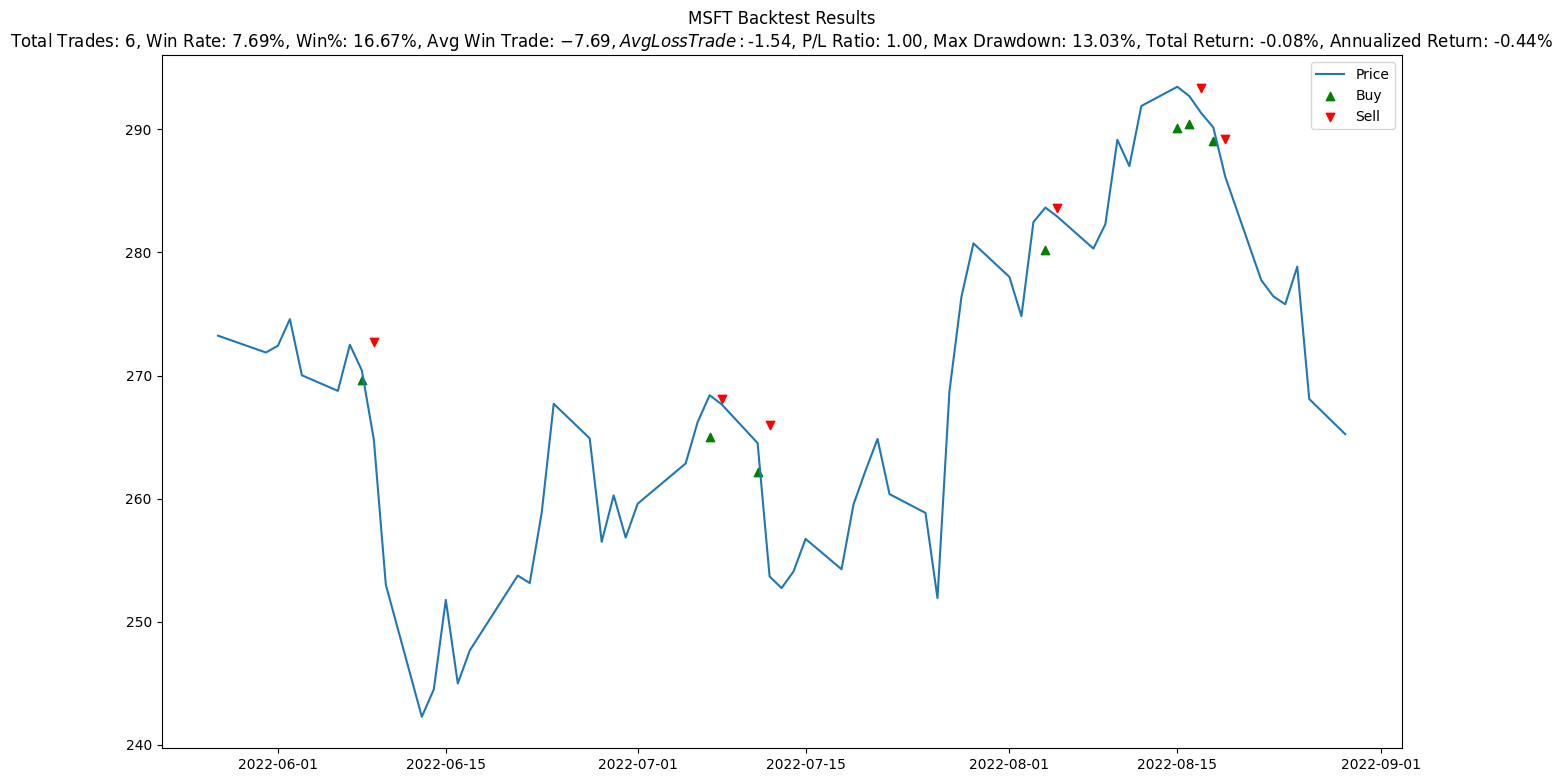

In [ ]:
backtest("MSFT", "2012-01-01", "2022-01-01", 10000, 0.02)

In [ ]:
# time frame increse, atleast 5 shares, indian shares, tradind view pe pine script run karni hai,